
#DSCI 417 – Project 01
##Analysis of NASA Server Logs
**Adam Sneed**

##Part A: Set up Environment
In this part of the project, we will set up our environment.

We will begin with some import statements.

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

We will now create our SparkSession and SparkContext objects.

In [0]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

##Part B: Load and Process Data
In this section, we will load in and process the NASA data file.

We begin by loading the data file into an RDD.

In [0]:
nasa_raw = sc.textFile('/FileStore/tables/NASA_server_logs_Aug_1995.txt')
print(nasa_raw.count())

1569888


We will now print the first 10 elements of this RDD.

In [0]:
for row in nasa_raw.take(10):
    print(row)

in24.inetnebr.com [01/Aug/1995:00:00:01] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt" 200 1839
uplherc.upl.com [01/Aug/1995:00:00:07] "GET /" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/ksclogo-medium.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/MOSAIC-logosmall.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/USA-logosmall.gif" 304 0
ix-esc-ca2-07.ix.netcom.com [01/Aug/1995:00:00:09] "GET /images/launch-logo.gif" 200 1713
uplherc.upl.com [01/Aug/1995:00:00:10] "GET /images/WORLD-logosmall.gif" 304 0
slppp6.intermind.net [01/Aug/1995:00:00:10] "GET /history/skylab/skylab.html" 200 1687
piweba4y.prodigy.com [01/Aug/1995:00:00:10] "GET /images/launchmedium.gif" 200 11853
slppp6.intermind.net [01/Aug/1995:00:00:11] "GET /history/skylab/skylab-small.gif" 200 9202


We will now process each line of server information by removing the double quotes, tokenizing the strings, replacing the hyphens that appear for the number of bytes with zeros, and coercing the values into appropriate datatypes.

In [0]:
def process_row(row):
    row = row.replace('"', '')
    tokens = row.split(' ')

    if tokens[-1] == '-':
        tokens[-1] = '0'

    tokens[-1] = int(tokens[-1])

    return tokens

nasa = nasa_raw.map(process_row)

nasa.persist()

for element in nasa.take(10):
    print(element)


['in24.inetnebr.com', '[01/Aug/1995:00:00:01]', 'GET', '/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', '200', 1839]
['uplherc.upl.com', '[01/Aug/1995:00:00:07]', 'GET', '/', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/ksclogo-medium.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/MOSAIC-logosmall.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/USA-logosmall.gif', '304', 0]
['ix-esc-ca2-07.ix.netcom.com', '[01/Aug/1995:00:00:09]', 'GET', '/images/launch-logo.gif', '200', 1713]
['uplherc.upl.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/WORLD-logosmall.gif', '304', 0]
['slppp6.intermind.net', '[01/Aug/1995:00:00:10]', 'GET', '/history/skylab/skylab.html', '200', 1687]
['piweba4y.prodigy.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/launchmedium.gif', '200', 11853]
['slppp6.intermind.net', '[01/Aug/1995:00:00:11]', 'GET', '/history/skylab/skylab-small.gif', '200', 9202]


##Part C: Most Requested Resources
In this part of the project, we will determine which resources were requested the most frequently.

In [0]:
count_by_resource = (
    nasa
    .map(lambda tokens: (tokens[3], 1))
    .reduceByKey(lambda a, b: a + b)
    .map(lambda x: (x[1], x[0]))
    .sortByKey(ascending=False)
    .map(lambda x: (x[0], x[1]))
)

for element in count_by_resource.take(10):
    print(element)

(97410, '/images/NASA-logosmall.gif')
(75337, '/images/KSC-logosmall.gif')
(67448, '/images/MOSAIC-logosmall.gif')
(67068, '/images/USA-logosmall.gif')
(66444, '/images/WORLD-logosmall.gif')
(62778, '/images/ksclogo-medium.gif')
(43688, '/ksc.html')
(37826, '/history/apollo/images/apollo-logo1.gif')
(35138, '/images/launch-logo.gif')
(30347, '/')


## Part D: Most Common Request Origins
In this part of the project, we will determine which servers are the origins for the greatest number of requests.

In [0]:
count_by_origin = (
    nasa
    .map(lambda tokens: (tokens[0], 1))
    .reduceByKey(lambda a, b: a + b)
    .map(lambda x: (x[1], x[0]))
    .sortByKey(ascending=False)
    .map(lambda x: (x[0], x[1]))
)

for element in count_by_origin.take(10):
    print(element)

(6530, 'edams.ksc.nasa.gov')
(4846, 'piweba4y.prodigy.com')
(4791, '163.206.89.4')
(4607, 'piweba5y.prodigy.com')
(4416, 'piweba3y.prodigy.com')
(3889, 'www-d1.proxy.aol.com')
(3534, 'www-b2.proxy.aol.com')
(3463, 'www-b3.proxy.aol.com')
(3423, 'www-c5.proxy.aol.com')
(3411, 'www-b5.proxy.aol.com')


##Part E: Request Types
In this part of the project, we will analyze records based on their request type. We will start by confirming that there are three different request types.

In [0]:
req_types = nasa.map(lambda tokens: tokens[2]).distinct().collect()

print(req_types)

['GET', 'HEAD', 'POST']


We will now count the number of requests of each type.

In [0]:
for req_type in req_types:
    req_type_count = nasa.filter(lambda tokens: tokens[2] == req_type).count()
    
    print(f"Request Type: {req_type}, Count: {req_type_count}")

Request Type: GET, Count: 1565812
Request Type: HEAD, Count: 3965
Request Type: POST, Count: 111


We will now determine the average number of bytes returned to the client for each request type.

In [0]:
avg_bytes = (
    nasa
    .map(lambda tokens: (tokens[2], (int(tokens[5]), 1)))
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    .map(lambda x: (x[0], round(x[1][0] / x[1][1])))
)

for element in avg_bytes.collect():
    print(element)

('GET', 17134)
('HEAD', 0)
('POST', 495)


##Part F: Status Codes
In this part of the project, we will analyze the status codes returned by the server.

In [0]:
status_codes = nasa.map(lambda tokens: tokens[4]).distinct().sortBy(lambda x: x, ascending=True).collect()

print(status_codes)

['200', '302', '304', '403', '404', '500', '501']


We will now determine which status codes appear for each request type.

In [0]:
for req_type in req_types:
    status_code = (
        nasa
        .filter(lambda tokens: tokens[2] == req_type)
        .map(lambda tokens: tokens[4])
        .distinct()
        .sortBy(lambda x: x, ascending=True)
        .collect()
    )

    print(f"Status codes for {req_type} requests: {', '.join(status_codes)}")


Status codes for GET requests: 200, 302, 304, 403, 404, 500
Status codes for HEAD requests: 200, 302, 404
Status codes for POST requests: 200, 404, 501


Next, we will count the number of requests resulting in each status code.

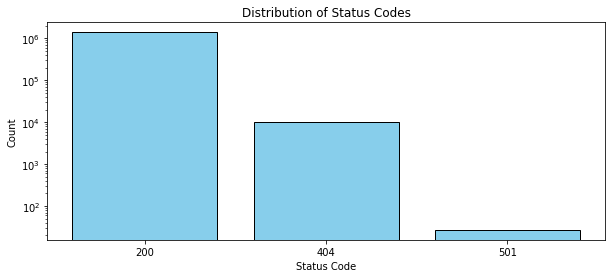

In [0]:
code_counts = []

for status_code in status_codes:
    count = nasa.filter(lambda tokens: tokens[4] == status_code).count()
    
    code_counts.append(count)

plt.figure(figsize=[10, 4])
bar_color = 'skyblue'
border_color = 'black'
plt.bar(status_codes, code_counts, color=bar_color, edgecolor=border_color)
plt.title('Distribution of Status Codes')
plt.xlabel('Status Code')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

##Part G: Request Volume by Day
In the final part of this project, we will determine the number of requests received by the server during each day in August 1995.

We will start this section by creating a the list counts_by_day.

In [0]:
counts_by_day = (
    nasa 
    .map(lambda tokens: (tokens[1][1:3], 1))
    .reduceByKey(lambda a, b: a + b)
    .sortByKey(ascending=True)
    .collect()
)

print(counts_by_day[:5])

[('01', 33996), ('03', 41388), ('04', 59557), ('05', 31893), ('06', 32420)]


We will now create a bar chart to display the distribution of requests by the day of the month.

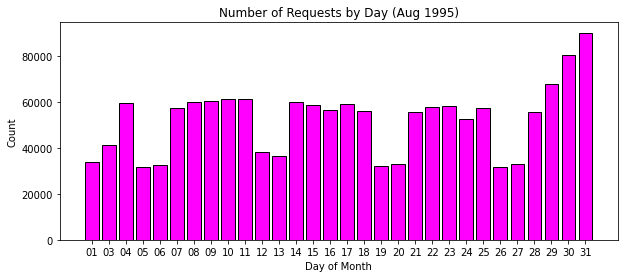

In [0]:
day_list, count_list = zip(*counts_by_day)

plt.figure(figsize=[10, 4])
bar_color = 'magenta'
border_color = 'black'
plt.bar(day_list, count_list, color=bar_color, edgecolor=border_color)
plt.title('Number of Requests by Day (Aug 1995)')
plt.xlabel('Day of Month')
plt.ylabel('Count')
plt.show()